# Machine Learning with text data

#### Can we predict whether a customer would recommend a purchased item of clothing based on solely their written review?

In this, my first project working with text data and applying Natural Language Processing (NLP) techniques, i'll be aiming to uncover the words that can predict whether or not a customer would recommend a purchased item of clothing. Which emotive words are most popular? Which aspect of the product is most important - the fit, colour, texture, price? And morever, what would such information mean for a retailer looking to best align their strategy to market demand? Well I'm not sure about you, but that's enough to spike my interest! We have 23,000 reviews and a binary classification target (recommendation) - let's crack on.

In [271]:
# First up, I'll import every library that will be used in this project is imported at the start.

# Data handling and processing
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.api as sm
from scipy.stats import randint as sp_randint
from time import time

# NLP
import nltk
nltk.download('wordnet')
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/josh24990/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now let's read in the data, all 23,000 clothing reviews. I'm only interested in three columns within this project, which have been seelcted below.

In [272]:
# Reading in data
data = pd.read_csv('/Users/josh24990/Library/Mobile Documents/com~apple~CloudDocs/Documents/Personal Development/3. Data Science/Python/NLP Project/Womens Clothing E-Commerce Reviews.csv')
data = data[['Clothing ID', 'Review Text', 'Recommended IND']]
data.columns = ['EmployeeID', 'Review Text', 'Recommend']

Upon first inspection, it looks like there are some missing reviews fill in.

In [273]:
# Inspecting the variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 3 columns):
EmployeeID     23486 non-null int64
Review Text    22641 non-null object
Recommend      23486 non-null int64
dtypes: int64(2), object(1)
memory usage: 550.5+ KB


In [274]:
# Replacing blank variables with 'unknown' ready for processing
data['Review Text'].fillna('unknown', inplace=True)

## 1. Text Preprocessing

Text is the most unstructured form of all the available data, therefore various types of noise are present in it. This means that the data is not readily analysable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing. This usually comprises two key steps:
<br>
1. Noise Removal
2. Lexicon Normalisation

### Noise Removal

Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise.

For example – language stopwords (commonly used words of a language – is, am, the, of, in etc), URLs or links, punctuations and industry specific words. This step deals with removal of all types of noisy entities present in the text.

Following is a python function to strip out noise throughout the reviews:

In [275]:
# Importing SKLearn's list of stopwords
stop = text.ENGLISH_STOP_WORDS

# Basic text cleaning function
def remove_noise(text):
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
    # Remove special characters
    text = text.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text = text.str.replace('\d+', '')
    
    # Remove Stopwords
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Convert to string
    text = text.astype(str)
        
    return text

In [276]:
# Applying noise removal function to data
data['Filtered Review Text'] = remove_noise(data['Review Text'])
data.head()

,EmployeeID,Review Text,Recommend,Filtered Review Text
0,767,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
1,1080,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happened store im glad ...
2,1077,I had such high hopes for this dress and reall...,0,high hopes dress really wanted work initially ...
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ti...
4,847,This shirt is very flattering to all due to th...,1,shirt flattering adjustable tie perfect length...


Before moving onto lexicon normalisation, I want to gain a sense of the sentiment per review. I don't intend to use this for any machine learning purposes, more-so out of interest to understand later whether reviews lean towards positivity or negativity. This will be looked at again later.

In [277]:
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
data['Polarity'] = sentiment_analyser(data['Filtered Review Text'])
data.head(10)

,EmployeeID,Review Text,Recommend,Filtered Review Text,Polarity
0,767,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable,0.633333
1,1080,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happened store im glad ...,0.318750
2,1077,I had such high hopes for this dress and reall...,0,high hopes dress really wanted work initially ...,0.037400
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ti...,0.500000
4,847,This shirt is very flattering to all due to th...,1,shirt flattering adjustable tie perfect length...,0.750000
5,1080,"I love tracy reese dresses, but this one is no...",0,love tracy reese dresses petite just feet tall...,0.116667
6,858,I aded this in my basket at hte last mintue to...,1,aded basket hte mintue look like person store ...,0.100833
7,858,"I ordered this in carbon for store pick up, an...",1,ordered carbon store pick ton stuff try used p...,0.145513
8,1077,I love this dress. i usually get an xs but it ...,1,love dress usually xs runs little snug bust or...,-0.046875
9,1077,"I'm 5""5' and 125 lbs. i ordered the s petite t...",1,im lbs ordered s petite make sure length wasnt...,0.250476


### Lexicon Normalisation

Another type of textual noise is about the multiple representations exhibited by single word.

For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”, Though they mean different but contextually all are similar. The step converts all the disparities of a word into their normalized form (also known as lemma). Normalization is a pivotal step for feature engineering with text as it converts the high dimensional features (N different features) to the low dimensional space (1 feature), which is an ideal ask for any ML model.

There are two methods of lexicon normalisation; Stemming or Lemmatization. I will opt for Lemmatization, as this will return the root form of each word (rather than just stripping suffixes, which is stemming).

In [278]:
# Instantiate the Word tokenizer & Word lemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
data['Filtered Review Text'] = data['Filtered Review Text'].apply(lemmatize_text)
data.head()

,EmployeeID,Review Text,Recommend,Filtered Review Text,Polarity
0,767,Absolutely wonderful - silky and sexy and comf...,1,"[absolutely, wonderful, silky, sexy, comfortable]",0.633333
1,1080,Love this dress! it's sooo pretty. i happene...,1,"[love, dress, sooo, pretty, happened, store, i...",0.318750
2,1077,I had such high hopes for this dress and reall...,0,"[high, hope, dress, really, wanted, work, init...",0.037400
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",1,"[love, love, love, jumpsuit, fun, flirty, fabu...",0.500000
4,847,This shirt is very flattering to all due to th...,1,"[shirt, flattering, adjustable, tie, perfect, ...",0.750000


# 2. Getting a text matrix

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using a variety of techniques – in this kernel I will be converting the data into statistical features.

The specific model in question is known as <b>'Term Frequency – Inverse Document Frequency' (TF – IDF)</b>

TF-IDF is a weighted model commonly used for information retrieval problems. It aims to convert the text documents into vector models on the basis of occurrence of words in the documents without taking considering the exact ordering. For Example – let say there is a dataset of N text documents, In any document “D”, TF and IDF will be defined as –

- <b>Term Frequency (TF)</b> – TF for a term “t” is defined as the count of a term “t” in a document “D”
- <b>Inverse Document Frequency (IDF)</b> – IDF for a term is defined as logarithm of ratio of total documents available in the corpus and number of documents containing the term T.
- <b>TF . IDF</b> – TF IDF formula gives the relative importance of a term in a corpus (list of documents), given by the following formula below. Following is the code using python’s scikit learn package to convert a text into tf idf vectors:

Scikit-learn provides two methods to get to our end result (a tf-idf weight matrix). One is a two-part process of using the CountVectorizer class to count how many times each term shows up in each document, followed by the TfidfTransformer class generating the weight matrix. The other does both steps in a single TfidfVectorizer class. In this Kernel I will proceed with method one; below is step 1:

In [279]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(data['Filtered Review Text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.9, max_features=None, min_df=0.005,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x1c18581620>, vocabulary=None)

In [280]:
# Getting the total n-gram count
len(cvec.vocabulary_)

886

I am happy with that number as a starting point, less than 1000 was my initial aim. If I wanted to be more or less restrictive on n-gram selection, I could adjust the 'min_df' and 'max_df' parameters within my CountVectorizer, which controls for the minimum and maximum amount of documents each word should feature in.

We can now embrace the next step, which is to turn this document into a <b>'bag of words' representation</b>, which essentially is just a separate column for each term containing the count within each document. After that, we’ll take a look at the <b>sparsity</b> of this representation which lets us know how many <b>nonzero values</b> there are in the dataset. The more sparse the data is the more challenging it will be to model, but that’s a discussion for another day:

In [281]:
# Creating the bag-of-words representation
cvec_counts = cvec.transform(data['Filtered Review Text'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (23486, 886)
nonzero count: 473238
sparsity: 2.27%


Now that we have term counts for each document, the TfidfTransformer can be applied to calculate the weights for each term in each document:

In [282]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<23486x886 sparse matrix of type '<class 'numpy.float64'>'
	with 473238 stored elements in Compressed Sparse Row format>

Great, we have our weighted words! Just a few more steps required (below); I'm going to extract all of the feature names (which are the n-grams) and put these into a DataFrame along with the corresponding weights per review. Then I am going to add in at the end some summary statistics to understand per review:

- The highest weighted word
- The weight of this word
- The total weighting per review.

In [283]:
# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)
model.head(10)

,able,absolutely,absolutely love,actually,add,added,addition,adorable,adore,ago,...,year,yellow,yes,yesterday,youre,zip,zipper,Keyword,Max,Sum
0,0.0,0.384864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,silky,0.548067,2.181111
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,bc,0.474526,4.486387
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.178346,0.156682,layer,0.449929,5.224752
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,love love,0.647011,2.700876
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,shirt,0.443253,3.277495
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,dress,0.385539,4.746780
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,trying,0.514505,4.146775
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,went,0.334038,4.852685
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,run little,0.333698,4.099005
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.178684,0.000000,0.000000,s,0.295541,5.907584


# 3. Data Exploration

Now that we have a td-idf weight matrix, this can be fed directly into a predictive model. Before we do this, let's explore the current data a little more:

### Merging datasets

In [284]:
# Merging td-idf weight matrix with original DataFrame
model = pd.merge(data, model, left_index=True, right_index=True)

In [285]:
# Printing the first 10 reviews left
model.head(10)

,EmployeeID,Review Text,Recommend,Filtered Review Text,Polarity,able,absolutely,absolutely love,actually,add,...,year,yellow,yes,yesterday,youre,zip,zipper,Keyword,Max,Sum
0,767,Absolutely wonderful - silky and sexy and comf...,1,"[absolutely, wonderful, silky, sexy, comfortable]",0.633333,0.0,0.384864,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,silky,0.548067,2.181111
1,1080,Love this dress! it's sooo pretty. i happene...,1,"[love, dress, sooo, pretty, happened, store, i...",0.318750,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,bc,0.474526,4.486387
2,1077,I had such high hopes for this dress and reall...,0,"[high, hope, dress, really, wanted, work, init...",0.037400,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.178346,0.156682,layer,0.449929,5.224752
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",1,"[love, love, love, jumpsuit, fun, flirty, fabu...",0.500000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,love love,0.647011,2.700876
4,847,This shirt is very flattering to all due to th...,1,"[shirt, flattering, adjustable, tie, perfect, ...",0.750000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,shirt,0.443253,3.277495
5,1080,"I love tracy reese dresses, but this one is no...",0,"[love, tracy, reese, dress, petite, just, foot...",0.116667,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,dress,0.385539,4.746780
6,858,I aded this in my basket at hte last mintue to...,1,"[aded, basket, hte, mintue, look, like, person...",0.100833,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,trying,0.514505,4.146775
7,858,"I ordered this in carbon for store pick up, an...",1,"[ordered, carbon, store, pick, ton, stuff, try...",0.145513,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,went,0.334038,4.852685
8,1077,I love this dress. i usually get an xs but it ...,1,"[love, dress, usually, x, run, little, snug, b...",-0.046875,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,run little,0.333698,4.099005
9,1077,"I'm 5""5' and 125 lbs. i ordered the s petite t...",1,"[im, lb, ordered, s, petite, make, sure, lengt...",0.250476,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.178684,0.000000,0.000000,s,0.295541,5.907584


### Checking out the most salient words

Let's see which words are most frequent throughout the matrix:

In [286]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Occurrences,Term
176,11320,dress
237,10096,fit
668,9355,size
443,8968,love
406,7018,like
110,6903,color
430,6873,look
837,6512,wear
291,6076,great
343,5988,im


It looks as though there is a definite positive lean throughout these most popular words, such as 'love', 'perfect' and 'flattering'. Now, let's see if the 20 highest weighted words throws up a similar list:

In [287]:
# Getting a view of the top 20 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

,Term,Weight
176,dress,0.051224
443,love,0.041398
237,fit,0.040412
668,size,0.038802
804,unknown,0.035979
291,great,0.033325
110,color,0.033161
430,look,0.032320
406,like,0.031847
837,wear,0.030934


Largely similar, albeit a slight difference in ranking. The reviews are looking good for this retailer currently! Let's find out a little more about this by inspecting the chosen target variable.

### Quick peak at the target variable

A binary variable 'Recommended' will be the focus of upcoming Machine Learning prediction. Let's see how the categories stack up:

1    19314
0     4172
Name: Recommend, dtype: int64


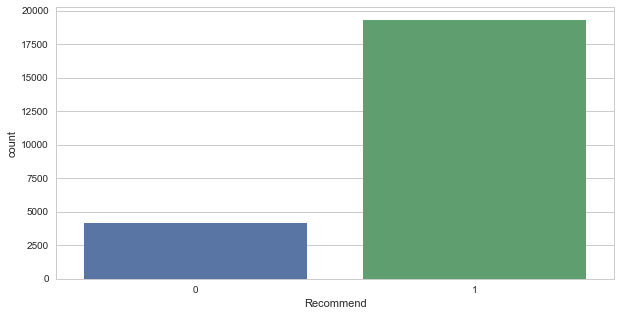

In [288]:
# Plotting overall recommendations and getting value counts
fig = plt.figure(figsize = (10,5))
sns.countplot(x='Recommend', data = model)

print(data['Recommend'].value_counts())

There are nearly four times as many recommendations than there are non-recommendations. We'll need to keep a note of this as this could throw up a few issues when training algorithms - i'll touch on this in a little while.

You will recall that I pulled a Polarity statistic during Step 1; let's see how this shapes up per target outcome:

Recommend
0    0.133673
1    0.266691
Name: Polarity, dtype: float64

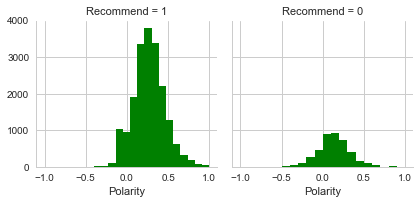

In [289]:
# Visualising polarity between recommending and non-recommending customers, then getting value counts
g = sns.FacetGrid(model, col="Recommend", col_order=[1, 0])
g = g.map(plt.hist, "Polarity", bins=20, color="g")

recommend = model.groupby(['Recommend'])
recommend['Polarity'].mean()

Comparing the above two graphs, it appears as though Polarity can recognise that reviews left by customers who recommended their product gave more positive reviews, compared to those who did not recommend. This bodes well for using our text matrix to predict recommendations.

With the weighted text matrix already created, there is no pressing need for any further preprocessing/engineering on these features. Therefore I dive straight into Machine Learning.

## 4. Machine Learning

While a lot of the statistics that I created earlier on such as Polarity and Keyword are interesting, I want to focus model predictions purely on the weighted text matrix. So, anything that doesn't feature as part of this will now be removed from the DataFrame.

### Set-up

In [290]:
# Get a list of columns for deletion
model.columns

Index(['EmployeeID', 'Review Text', 'Recommend', 'Filtered Review Text',
       'Polarity', 'able', 'absolutely', 'absolutely love', 'actually', 'add',
       ...
       'year', 'yellow', 'yes', 'yesterday', 'youre', 'zip', 'zipper',
       'Keyword', 'Max', 'Sum'],
      dtype='object', length=894)

In [291]:
# Drop all columns not part of the text matrix
ml_model = model.drop(['EmployeeID', 'Review Text', 'Filtered Review Text', 'Polarity', 'Keyword', 'Max', 'Sum'], axis=1)

# Create X & y variables for Machine Learning
X = ml_model.drop('Recommend', axis=1)
y = ml_model['Recommend']

# Create a train-test split of these variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

To help with Machine Learning I will define a function that will return the most prized statistics in one go. After instantiating a model, this function will return an mean accuracy score following 5 folds of cross validation - this is to ensure that we are getting a smoothed out representation of both the training and test sets. Next this function will provide us with the Confusion Matrix; how many correct vs incorrect classifications have actually taken place within the given model? Last up, this function will churn out for us a Classification Report which details other important metrics such as Precision, Recall, the F1 score (which is just the harmonic mean of the former two), and support (which is the classification count). 

Combined, these metrics will provide rich insight into individual model performance and will guide better selection towards the best performing model, and how best to optimise it.

In [292]:
# Defining a function to fit and predict ML algorithms
def model(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train))

Function defined - now let's get training! I'm only going to focus on four algorithms in this kernel, starting off with:

### Algorithms round 1

In [293]:
# 1. Gaussian Naive Bayes
gnb = GaussianNB()
model(gnb, "Gaussian Naive Bayes", X_train, y_train, X_test, y_test)

Gaussian Naive Bayes
Accuracy: 0.725
Confusion Matrix:  
 [[2445 4044]
 [ 469 9482]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.84      0.38      0.52      6489
          1       0.70      0.95      0.81      9951

avg / total       0.76      0.73      0.69     16440



In [294]:
# 2. Random Forest Classifier
ran = RandomForestClassifier(n_estimators=50)
model(ran, "Random Forest Classifier", X_train, y_train, X_test, y_test)

Random Forest Classifier
Accuracy: 0.867
Confusion Matrix:  
 [[ 1108   431]
 [ 1806 13095]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.38      0.72      0.50      1539
          1       0.97      0.88      0.92     14901

avg / total       0.91      0.86      0.88     16440



In [295]:
# 3. Logistic Regression
log = LogisticRegression()
model(log, "Logistic Regression", X_train, y_train, X_test, y_test)

Logistic Regression
Accuracy: 0.884
Confusion Matrix:  
 [[ 1431   416]
 [ 1483 13110]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.49      0.77      0.60      1847
          1       0.97      0.90      0.93     14593

avg / total       0.92      0.88      0.90     16440



In [296]:
# 4. Linear SVC
svc = LinearSVC()
model(svc, "Linear SVC", X_train, y_train, X_test, y_test)

Linear SVC
Accuracy: 0.885
Confusion Matrix:  
 [[ 1642   611]
 [ 1272 12915]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.56      0.73      0.64      2253
          1       0.95      0.91      0.93     14187

avg / total       0.90      0.89      0.89     16440



Four models down, and we're up to 88% Accuracy with the Linear SVC. However, there seems to be an issue with Class 0 (would not recommend) across all trained models; looking at the LinearSVC both Precision & Recall are low, contributing towards a mediocre 0.60 F1 score. 

My sense is this is due to class imbalance. As depicted earlier, there are around five times fewer 0 classifications compared to 1 classifications, which can sometimes be problematic within Machine Learning, whereby modelling generally tends to work better when there is an almost equal numbers of samples from each class in the target variable. With this dataset, we're way off that. 

To overcome this problem, we can either DownSample the majority Class or UpSample the minority class. In this notebook I will use an Oversampling technique from the handy SMOTE library. Let's apply this technique and then re-run all four models to re-assess precision & recall performance.

### Algorithms round 2

In [297]:
# Import the hopeful solution to our problems
from imblearn.over_sampling import SMOTE
smote=SMOTE()

In [298]:
# Setting up new variables for ML
X_sm, y_sm = smote.fit_sample(X,y)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

In [299]:
# Defining a new function with revised inputs for the new SMOTE variables
def model_sm(mod, model_name, x_train_sm, y_train_sm, x_test_sm, y_test_sm):
    mod.fit(x_train_sm, y_train_sm)
    print(model_name)
    acc = cross_val_score(mod, X_train_sm, y_train_sm, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, X_train_sm, y_train_sm, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train_sm)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train_sm))

In [300]:
# 1. Gaussian Naive Bayes
gnb = GaussianNB()
model_sm(gnb, "Gaussian Naive Bayes", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Gaussian Naive Bayes
Accuracy: 0.838
Confusion Matrix:  
 [[11738  2580]
 [ 1811 10910]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.87      0.82      0.84     14318
          1       0.81      0.86      0.83     12721

avg / total       0.84      0.84      0.84     27039



In [301]:
# 2. Random Forest Classifier
ran = RandomForestClassifier(n_estimators=50)
model_sm(ran, "Random Forest Classifier", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Random Forest Classifier
Accuracy: 0.911
Confusion Matrix:  
 [[12414  1194]
 [ 1135 12296]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.92      0.91      0.91     13608
          1       0.91      0.92      0.91     13431

avg / total       0.91      0.91      0.91     27039



In [302]:
# 3. Logistic Regression
log = LogisticRegression()
model_sm(log, "Logistic Regression", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Logistic Regression
Accuracy: 0.881
Confusion Matrix:  
 [[12036  1697]
 [ 1513 11793]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.89      0.88      0.88     13733
          1       0.87      0.89      0.88     13306

avg / total       0.88      0.88      0.88     27039



In [303]:
# 4. Linear SVC
svc = LinearSVC()
model_sm(svc, "Linear SVC", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Linear SVC
Accuracy: 0.882
Confusion Matrix:  
 [[12040  1686]
 [ 1509 11804]]
                    Classification Report 
              precision    recall  f1-score   support

          0       0.89      0.88      0.88     13726
          1       0.88      0.89      0.88     13313

avg / total       0.88      0.88      0.88     27039



We're in business; a drastic improvement on Precision & Recall across all algorithms, even complemented with improved overall acccuracy on a couple as well. It's great to see the Naive Bayes Classifier now up at 85%, as this algorithm is typically well suited to crunching text data. However now exceeding the 90% bracket is the Random Forest Classifier, also boasting great Precision & Recall values too.

## 5. Best Model: Random Forest Classifier

Given that the Random Forest now heads the pack in terms of accuracy, let's proceed with some further exploration and perhaps a spot of optimisation too. I'll begin with visualising the top predictive features from the Random Forest Classifier:

### Assessing feature importance

In [304]:
# Creating a plot for feature importance
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

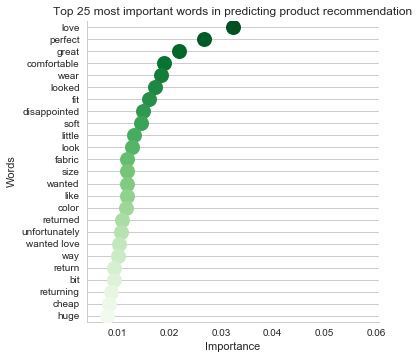

In [312]:
# Compile arrays of columns (words) and feature importances
fi = {'Words':ml_model.drop('Recommend',axis=1).columns.tolist(),'Importance':ran.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 20
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph!
titles = ["Top 25 most important words in predicting product recommendation"]
importance_plotting(Importance,'Importance','Words','Greens_r',titles)

Taking the win by a clear margin as the strongest predictor of product recommendation is the word 'love'. This shouldn't come as too much of a surprise given that 'love' is a highly emotive word that conveys a larger feeling of positivity, as opposed to 'like' or 'nice', for example. Not just positive words but also negative ones such as 'disappointed' and 'unfortunately' have been useful in the prediction. 

Of particular interest to a retailer <i>might</i> be words such as:
- Soft / Comfortable: Revealing the importance of texture, and how the clothes actually feel
- Fit / Size: Both similar in nature and high ranking, the product needs to fit well.
- Cheap: This word features in the top list, but quite far down the list! How important is price when reviewing a product at this retailer?

### Precision-Recall Curve

For each person the Random Forest algorithm classifies, it computes a probability based on a function and it classifies the review as 'Recommended' (when the score is bigger than the <b>threshold</b>) or as 'Not Recommended' (when the score is smaller than the <b>threshold</b>). This information can be displayed visually as a 'Presicion-Recall curve', which has usefulness in allowing us to tailor n algorithm to more exact precision and recall requirements. The below code will generate this for us:

In [306]:
# Getting prediction probabilities
y_scores = ran.predict_proba(X_train_sm)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train_sm, y_scores)

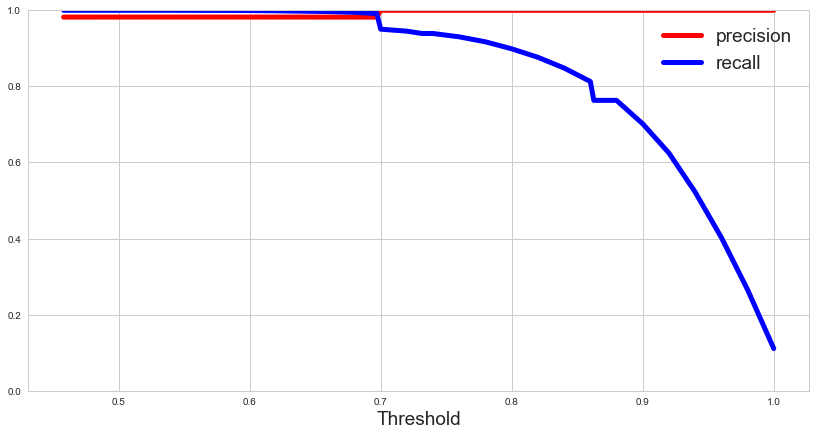

In [307]:
# Defining a new function to plot the precision-recall curve
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

The optimum Precision/Recall threshold here looks within the region of 0.7, thereafter Recall plummets eventually down to near zero.

### ROC-AUC Curve

AUC is a metric for binary classification.

Accuracy deals with ones and zeros, meaning you either got the class label right or you didn’t. But many classifiers are able to quantify their uncertainty about the answer by outputting a probability value. To compute accuracy from probabilities you need a threshold to decide when zero turns into one. The most natural threshold is of course 0.5.

Let’s suppose you have a quirky classifier. It is able to get all the answers right, but it outputs 0.7 for negative examples and 0.9 for positive examples. Clearly, a threshold of 0.5 won’t get you far, but 0.8 would be just perfect.

That’s the whole point of using AUC - it considers all possible thresholds. Various thresholds result in different true positive/false positive rates. As you decrease the threshold, you get more true positives, but also more false positives. The relation between them can be plotted:

In [308]:
# Compute the true positive and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_sm, y_scores)

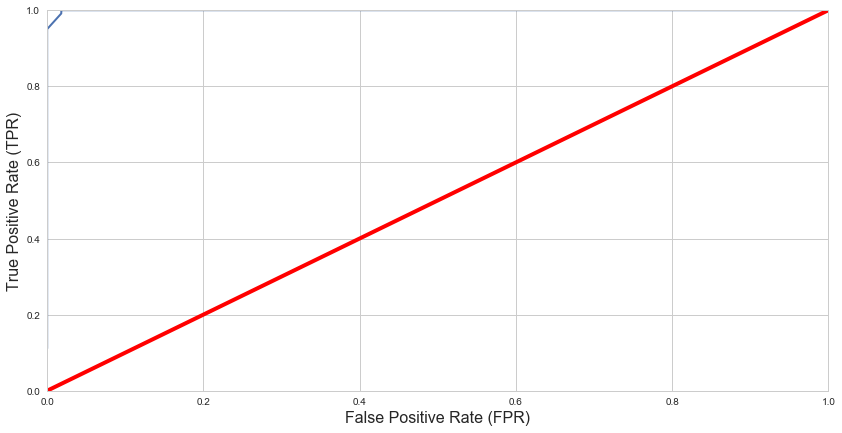

In [309]:
# Plotting the true positive and false positive rate
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The red line represents a purely random classifier (e.g a coin flip), so the aim is for our classifier (represented by the blue ROC curve) to be as far away from it as possible. This space under the curve is known as the AUC, and therefore a larger AUC space is indicative of a better model. For this Random Forest Classifier model, the graph therefore indicates very strong model performance (hoo-rah)!

### ROC-AUC score

Lastly, we will compute the size of this AUC space, known as the ROC-AUC score.

In [310]:
# Computing the ROC-AUC score
r_a_score = roc_auc_score(y_train_sm, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9994731994641967


Backing up the graph, a very strong ROC-AUC Score of over 99% has been achieved by this model.

## 6. Conclusion

Job done! In this kernel we have:

- Started with an unstructured table of 23,000 clothing text reviews and corresponding Recommend vs Not Recommend classifications.
- Taken the text reviews, cleaned them and built them into a matrix
- Briefly explored the data before applying initial Machine Learning Algorithms
- Balanced the unvenly weighted target variables before re-running the same Algorithms with improved findings
- Identified the best performing model (Random Forest Classifier), explored it's most important features and computed further Precision/Recall metrics (including ROC-AUC).
- Achieved a final accuracy score of 91.1% on the model's training dataset, and an ROC-AUC score of 99.9%.

I've enjoyed working with this dataset and have learned heaps around using text data to predict an outcome - given this has been my first exposure to working with text, the buzz in being able to do just this has been great! It has also been an enjoyable experience using this data to predict genuinely meaningful and useful insights, such as knowing what consumers are looking for in a clothing product, and what matters most to them.

In terms of how this kernel could be extended or improved, we could:

- Take a more rigorous approach to mining the text data, such as categorising products, controlling for spelling errors / using more advanced modelling techniques such as topic modelling
- Make better use of the Polarity metric within Machine Learning
- Apply a more extensive list of algorithms (including Deep Learning) to the text data
- Apply GridSearchCV to optimise the final model
- Create an ensemble of models for better prediction

Perhaps I will return to some or all of these points at a later date :). For now however, <b>thank you</b> for reading this kernel! Please do feel free to share with me your thoughts, feedback and any suggestions for improvement - I am always willing to learn new or more efficient techniques! Cheers. 